## Network Optimization exam June 04, 2019 R1

## Exercise 1

The  graph ``graph04062019R1.gml`` contains  a  set  of potential customers that a telecom company can connect with a network rooted in node 1. Each location(node) $u$ has associated a revenue \[``revenue`` attribute in the graph\] and each edge $uv$ has a connection cost \[``cost`` attribute in the graph\].


1. Assuming that the company must connect all customers, find the most profitable implementation between the following networks configuration:
- **Net1**: a network in which each node (excluding the root) can accept up to 3 connections
- **Net2**: a  network in  which the  root  node can  accept  up to 4 connections.

2. If the company may connect only a subset of customers, find the most profitable network with the constraint that the number of hops from the root node cannot exceed 4.

3. **\[Bonus\]** The  network  in  Q2  can  be  extended  by  installing  in each terminal  node a  router that can connect  up  to three nodes in  the neighbourhood at  half  the  connection  costs. Find  the  most  profitable network extension that connects all customers (the cost of the router is 150 Euro).

In [1]:
import networkx as nx
import gurobipy as gb
import os
from IPython.display import SVG, display
import matplotlib.pyplot as plt



In [2]:
class args:
    filename = None
    scale = 40
    figsize = (6,6)
    
def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        

    
    #edges_in_sol = [(u,v)  for u,v in G.edges() if x[u,v].x > 0.1]

    
    plt.axis('off')
    plt.show()

In [29]:
args.filename = "graph04062019R1.gml"
args.figsize = 14,14

basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 30 nodes and 435 edges


## Question 1
The problem can be modeled as the Minimum Spanning Tree with extra degree constraints. 
I use the Multicommodity Flow formulation for the MST. Note that I relabel the nodes starting from 
0 


In [30]:
G = nx.convert_node_labels_to_integers(G, first_label=0,label_attribute='old' )

In [31]:
G.nodes(data=True)

NodeDataView({0: {'y': 65, 'x': 10, 'revenue': 310, 'old': 1}, 1: {'y': 19, 'x': 9, 'revenue': 843, 'old': 2}, 2: {'y': 8, 'x': 35, 'revenue': 1578, 'old': 3}, 3: {'y': 17, 'x': 1, 'revenue': 813, 'old': 4}, 4: {'y': 35, 'x': 21, 'revenue': 1452, 'old': 5}, 5: {'y': 57, 'x': 15, 'revenue': 1031, 'old': 6}, 6: {'y': 5, 'x': 26, 'revenue': 487, 'old': 7}, 7: {'y': 20, 'x': 30, 'revenue': 491, 'old': 8}, 8: {'y': 50, 'x': 29, 'revenue': 559, 'old': 9}, 9: {'y': 19, 'x': 34, 'revenue': 622, 'old': 10}, 10: {'y': 34, 'x': 5, 'revenue': 917, 'old': 11}, 11: {'y': 1, 'x': 34, 'revenue': 1175, 'old': 12}, 12: {'y': 12, 'x': 23, 'revenue': 1064, 'old': 13}, 13: {'y': 22, 'x': 11, 'revenue': 930, 'old': 14}, 14: {'y': 37, 'x': 11, 'revenue': 1354, 'old': 15}, 15: {'y': 12, 'x': 19, 'revenue': 1259, 'old': 16}, 16: {'y': 12, 'x': 3, 'revenue': 511, 'old': 17}, 17: {'y': 32, 'x': 28, 'revenue': 1169, 'old': 18}, 18: {'y': 45, 'x': 1, 'revenue': 679, 'old': 19}, 19: {'y': 37, 'x': 14, 'revenue': 43

In [32]:
pos = {i:(G.nodes[i]['x'] * args.scale,G.nodes[i]['y'] * args.scale) for i in G.nodes()}

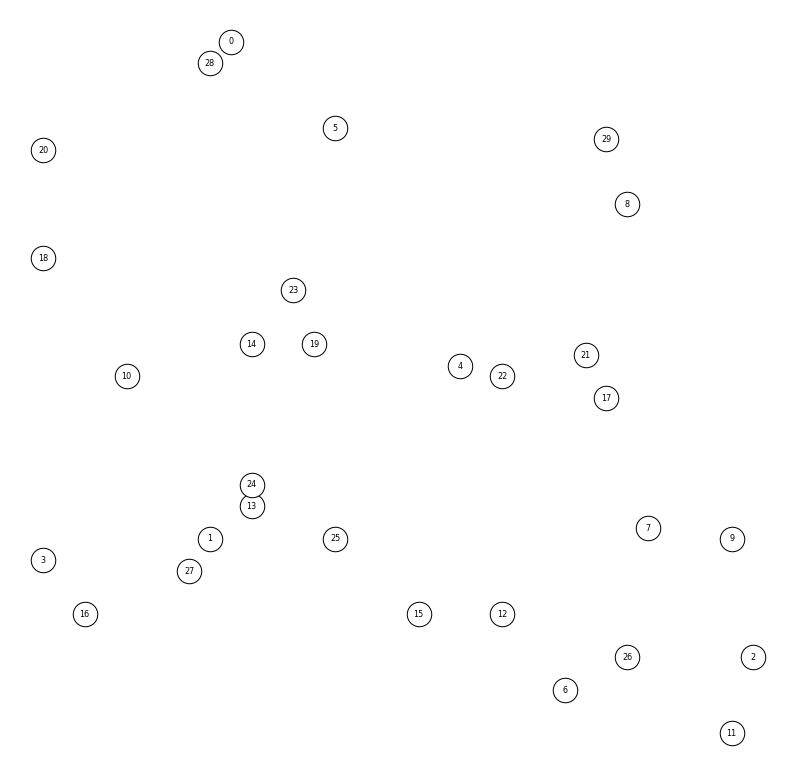

In [33]:
DrawInitG(G)

In [35]:
G.nodes()
root = 0

D = G.to_directed()

mstmulti = gb.Model()

x = mstmulti.addVars(G.edges(), obj=[G[u][v]['cost'] for u,v in G.edges()],\
                    ub = 1.0,\
                    vtype=gb.GRB.BINARY,\
                    name='x')


y = mstmulti.addVars(D.nodes(), \
                     obj=[G.nodes[i]['revenue'] for i in G.nodes()],\
                         ub=1.0, vtype=gb.GRB.BINARY,\
                         name='y')

commodities = list(G.nodes())[1:]
commodities

f = mstmulti.addVars(D.edges(), \
                         commodities, \
                         ub=G.number_of_nodes(), \
                         vtype=gb.GRB.CONTINUOUS, \
                         name='f')


# ROOT CONSTRAINTS: there is one constraint for each commodity

for k in commodities:
    name = "Root_Com_"+str(k)
    mstmulti.addConstr(f.sum(root, '*', k) - \
                           f.sum('*',root,k) \
                           == 1, name)

mstmulti.update()

mstmulti.write('multi.lp')

# BALANCE CONSTRAINTS: written for all nodes different from root and for nodes different
# from the terminal of each commodity

for v in commodities:
    for k in commodities:
        if (v != k):
            name = "Balance_"+str(v)+"_Com_"+str(k)
            mstmulti.addConstr(f.sum('*',v,k) - f.sum(v,'*',k) == 0, name)
            

mstmulti.update()


mstmulti.write('multi.lp')

# TERMINAL CONSTRAINTS: there is one constraint for each commodity

for k in commodities:
    name = "Term_Com_"+str(k)
    mstmulti.addConstr(f.sum('*',k,k) - f.sum(k,'*',k) == 1, name)

mstmulti.update()


mstmulti.write('multi.lp')

# VARIABLE CAPACITY constraints

for k in commodities:
    for i,j in D.edges():
        name = "Cap_(%d,%d)" % (i,j) + "_Com_" + str(k)
        mstmulti.addConstr (f [i,j,k] - y[i,j] <= 0, name)

mstmulti.update()


mstmulti.write('multi.lp')

# CARDINALITY constraint

mstmulti.addConstr(y.sum() == G.number_of_nodes() - 1, "Cardinality")

mstmulti.update()

# EQUALITY constraints

for i,j in G.edges():
 
    name = "Equality_x_(%d,%d)"%(i,j)
    mstmulti.addConstr(y[i,j] + y[j,i] -  x[i,j] == 0, name)
    
mstmulti.update()

mstmulti.write('multi.lp')

mstmulti.optimize()

KeyError: (0, 1)

In [ ]:
DrawSol(G,x)

This is the solution of the MST without degree constraints. One can note that the root node has only 4 connections. Thus, it satisfies  the **Net2** constraints

Now, I add the degree constraints in all nodes but the root node to fulfill requirements of **Net1**

In [36]:
mstmulti.addConstrs((x.sum(i, '*') <= 3 for i in list(G.nodes())[1:]))

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>,
 22: <gurobi.Constr *Awaiting Model Update*

In [37]:
    mstmulti.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 899 rows, 25695 columns and 50866 nonzeros
Model fingerprint: 0x6323b6da
Variable types: 25230 continuous, 465 integer (465 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 7e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


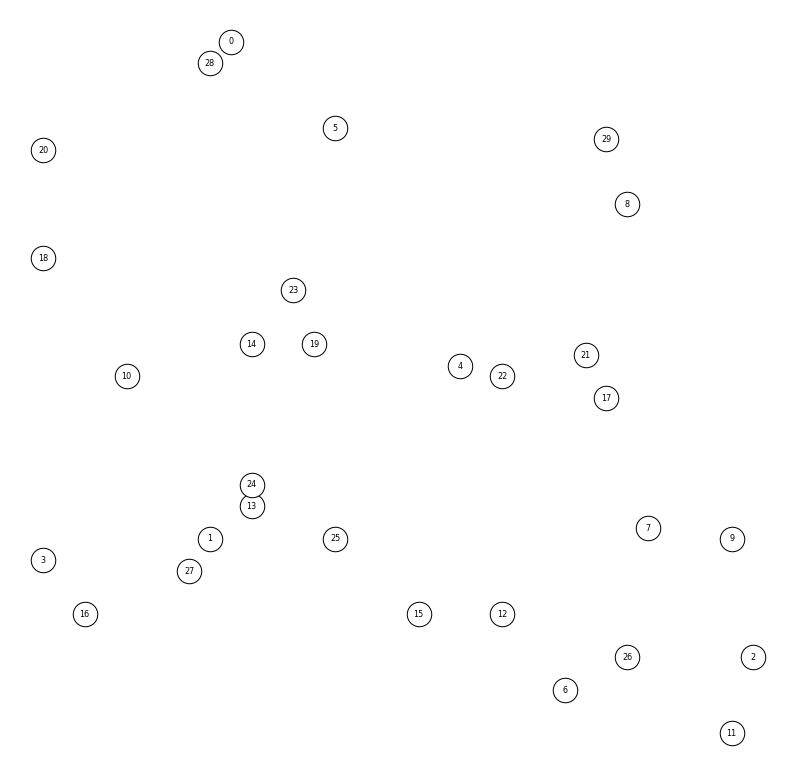

In [38]:
DrawSol(G,x)

Then, **Net1** is cheaper than **Net2**

## Question 2
The problem can be modeled as a Price Collecting Steiner Tree with Hop Constraints.
The maximum number of hops is $H=4$

In [13]:
root = 0

pcst = gb.Model()


# H represents the maximum number of hops

H = 4



#
# Variables definition
#


x = pcst.addVars(D.edges(), vtype=gb.GRB.BINARY,\
                 obj = [- D[i][j]['cost'] for (i,j) in D.edges()], \
                 name = 'x')

y = pcst.addVars (G.nodes(), vtype = gb.GRB.BINARY,\
                  obj = [G.nodes[i]['revenue'] for i in G.nodes()],\
                 name = 'y')

u = pcst.addVars (G.nodes(), vtype = gb.GRB.CONTINUOUS, \
                  lb = 0.0, ub = G.number_of_nodes(),\
                 name = 'u')


pcst.ModelSense = gb.GRB.MAXIMIZE

#
# Root is in the solution
#

pcst.addConstr(y[root] == 1, name = 'Fix')

pcst.update()

#
# Each node has exactly one incoming arc
#

pcst.addConstrs((x.sum('*',j) == y[j] for j in G.nodes() if j != root), name='Node')

pcst.update()

#
# Precedence constraints (MTZ constraints)
#

pcst.addConstrs(((H + 1) * x[i,j] \
                + u[i] - u[j] <= H for i,j in D.edges()),\
                name = 'MTZ')

pcst.update()


#
# Connectivity constraints
#

pcst.addConstrs((x[j,k] <= y[j] for j in G.nodes() \
                 if j != root for k in D.neighbors(j)), name = 'Connect')

pcst.update() 



pcst.addConstrs ((u[i] >= y[i] for i in G.nodes() \
                  if i != root), name='VLB')

pcst.update()


pcst.addConstrs ((u[i] <= H * y[i] for i in G.nodes() \
                  if i != root), name='VUB')

pcst.update()

pcst.write('pcst-hop.lp')

pcst.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1799 rows, 930 columns and 5279 nonzeros
Model fingerprint: 0xce3f228e
Variable types: 30 continuous, 900 integer (900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+02, 7e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 310.0000000
Presolve removed 59 rows and 31 columns
Presolve time: 0.01s
Presolved: 1740 rows, 899 columns, 5104 nonzeros
Variable types: 29 continuous, 870 integer (870 binary)

Root relaxation: objective 1.373380e+04, 88 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 13733.8000    0   24  310.00000 13733.8000  4330%     -    0s
H    0     0                    1424.0000000 

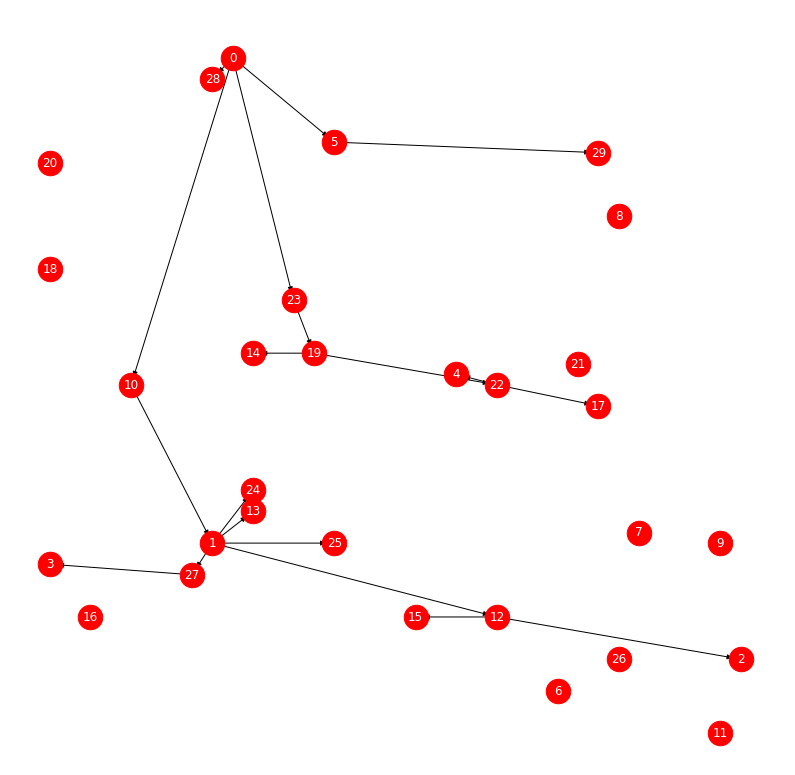

In [14]:
DrawSol(D,x)

## Bonus question (not implemented)

To solve the bonus question you need to assign each uncovered node to a node of the backbone network. So, you can formulate a capacitated facility location problem in which each node in the backbone (but the root) represents a facility and each node outside the backbone represents a client. Each node in the backbone cannot serve more than three customer nodes.

## Exercise 2

The graph ``atsp04062019R1.gml`` represents a logistic distribution network. A company must deliver daily one unit of a certain product to customers located in the nodes. The company can implement the following delivering plans:

1. Rent a vehicle with capacity $C=50$ at a cost of 3400 Euro/day
2. Rent one vehicle with capacity $C=18$ at a cost of 1100 Euro/day and rent a warehouse in node 16 able to store products at a cost of 2100 Euro/day
3. Rent two vehicles with capacity $C=18$   at a cost of 1650 Euro/day per vehicle.

Find the most convenient delivering plan. For each alternative report the optimal solution, the value of the linear relaxation and the number of enumerated nodes.

In [15]:
import gurobipy as gb
import networkx as nx
import matplotlib.pyplot as plt
import os


#
# Drawing 
# functions
#


def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
        
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
        

    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
    
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        


        
        
    
    plt.axis('off')
    plt.show()


def DrawSubtour (G, x, subtour):

    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}


    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
    
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o',
                           nodelist=subtour,
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
        
    

    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    subtouredges = [(u,v) for u in subtour for v in subtour if u != v and G.has_edge(u,v)]
    
    for u,v in subtouredges:
        if x[u,v].x > 0.01 and x[u,v].x < 0.99:

            nx.draw_networkx_edges(G, pos=pos,\
                                   edgelist=[(u,v)],
                                   edge_color='r')

            nx.draw_networkx_edge_labels(G, pos=pos, 
                                         edge_labels={(u,v):f'[{x[u,v].x:.2f}, {x[v,u].x:.2f}]'})

            
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,\
                                   edgelist=[(u,v)],\
                                   edge_color='k')
            
    plt.axis('off')
    plt.show()
    
class args:
    filename = None
    scale = 15
    figsize = (10,10)

## Question 1

One can calculate the first configuration by solving an ATSP model. First we read the graph.

In [16]:
# 
# Read the graph in the graphML format
#


args.filename = 'atsp04062019R1.gml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

print(G.is_directed())

args.figsize = (20,20)

#print(G.edges(data=True))

G has 30 nodes and 870 edges
True


In [17]:
root = 1

atsp_mtz = gb.Model()



x = atsp_mtz.addVars(G.edges(),
                     obj=[G[i][j]['dist'] for i,j in G.edges()],
                     vtype=gb.GRB.BINARY, name='x')

u = atsp_mtz.addVars(G.nodes(), 
                     obj=[0.0 for i in G.nodes()],
                     lb=2.0, ub=G.number_of_nodes(), 
                     vtype=gb.GRB.CONTINUOUS,
                     name='u')

atsp_mtz.write('atsp_mtz.lp')

atsp_mtz.addConstrs((x.sum(i,'*') == 1 for i in G.nodes()), name='FS')

atsp_mtz.update()


atsp_mtz.addConstrs((x.sum('*',i) == 1 for i in G.nodes()), name='RS')

atsp_mtz.update()


atsp_mtz.addConstrs((u[i] - u[j] + (G.number_of_nodes() - 1) * x[i,j] + \
                   (G.number_of_nodes() - 3) * x[j,i] <= (G.number_of_nodes() - 2)\
                   for i in G.nodes()\
                    for j in G.nodes()\
                   if (i != j) and (i != root) and (j !=root) \
                     and G.has_edge(i,j) and G.has_edge(j,i)), name='MTZ')

atsp_mtz.update()
atsp_mtz.write('atsp_mtz.lp')

u[root].lb = 1.0
u[root].ub = 1.0




In [18]:
atsp_mtz.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 872 rows, 900 columns and 4988 nonzeros
Model fingerprint: 0x59141e18
Variable types: 30 continuous, 870 integer (870 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [2e+02, 7e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 872 rows, 899 columns, 4988 nonzeros
Variable types: 29 continuous, 870 integer (870 binary)
Found heuristic solution: objective 80645.000000

Root relaxation: objective 2.655947e+04, 138 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 26559.4700    0   57 80645.0000 26559.4700  67.1%     -    0s
H    0     0                    34203.000000 26

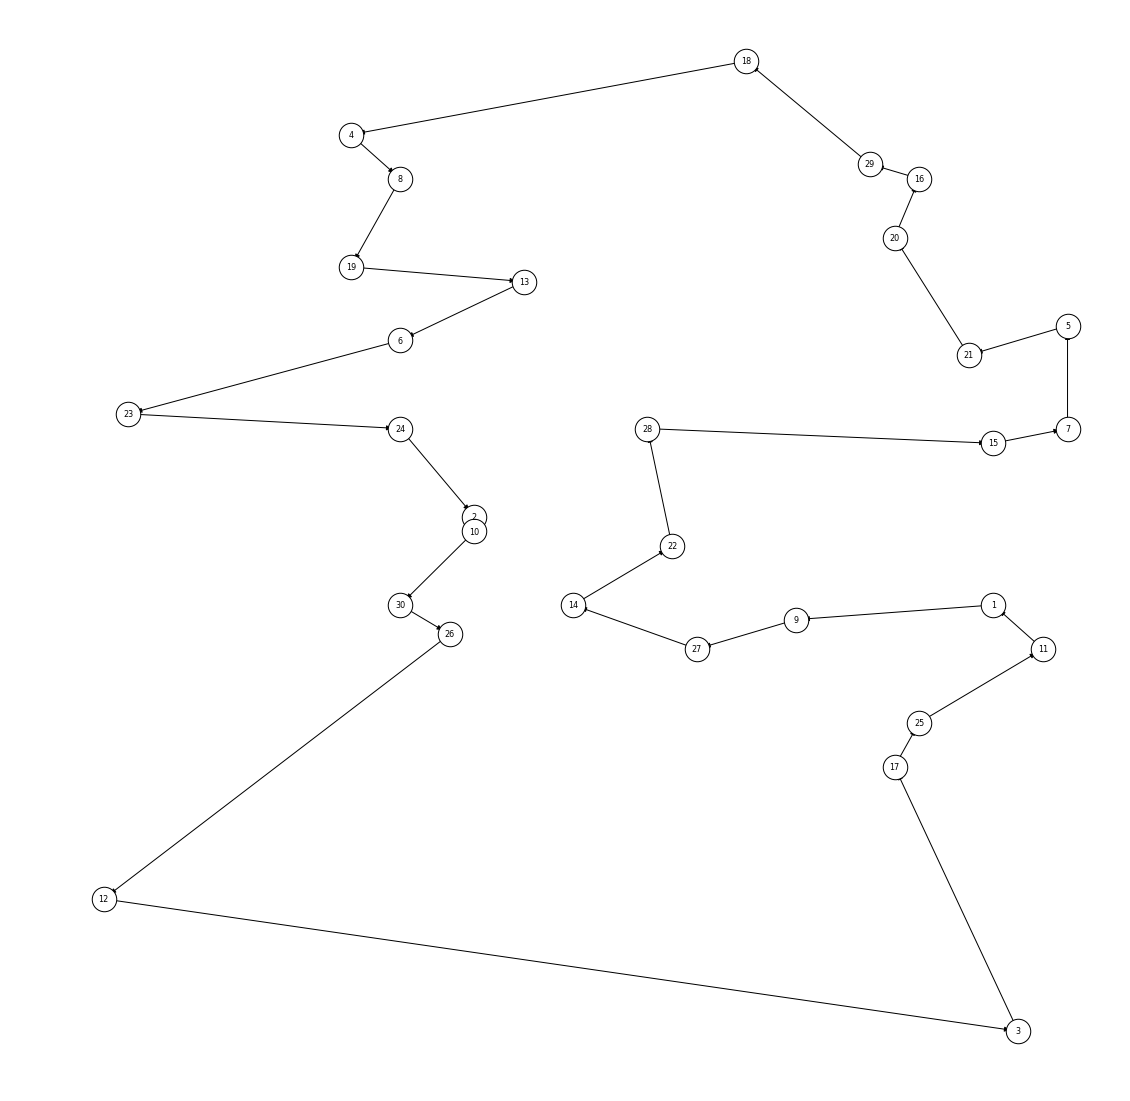

In [19]:
DrawSol(G,x)

* **Delivery cost**: 27720
* **Vehicle cost**: 3400 
* **Storage cost**: 0

### Total cost: 31120

## Question 2
In this case we deliver using a vehicle with capacity $C=18$. This means that the intermediate stop in the warehouse 
located at node 16 must occurs not after the visit of 18 nodes but the root (that is $u[16] \le 19$) and not 
before the visit of 10 nodes (that is, $u[16] \ge 10$). This implies that you have to add the following:

In [20]:
u[16].lb = 10.0
u[16].ub = 19.0

In [21]:
atsp_mtz.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 872 rows, 900 columns and 4988 nonzeros
Model fingerprint: 0x6ead3506
Variable types: 30 continuous, 870 integer (870 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [2e+02, 7e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+01]

MIP start from previous solve produced solution with objective 27720 (0.00s)
Loaded MIP start from previous solve with objective 27720

Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 872 rows, 899 columns, 4988 nonzeros
Variable types: 29 continuous, 870 integer (870 binary)

Root relaxation: objective 2.655947e+04, 133 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 26559.4700    0   57 

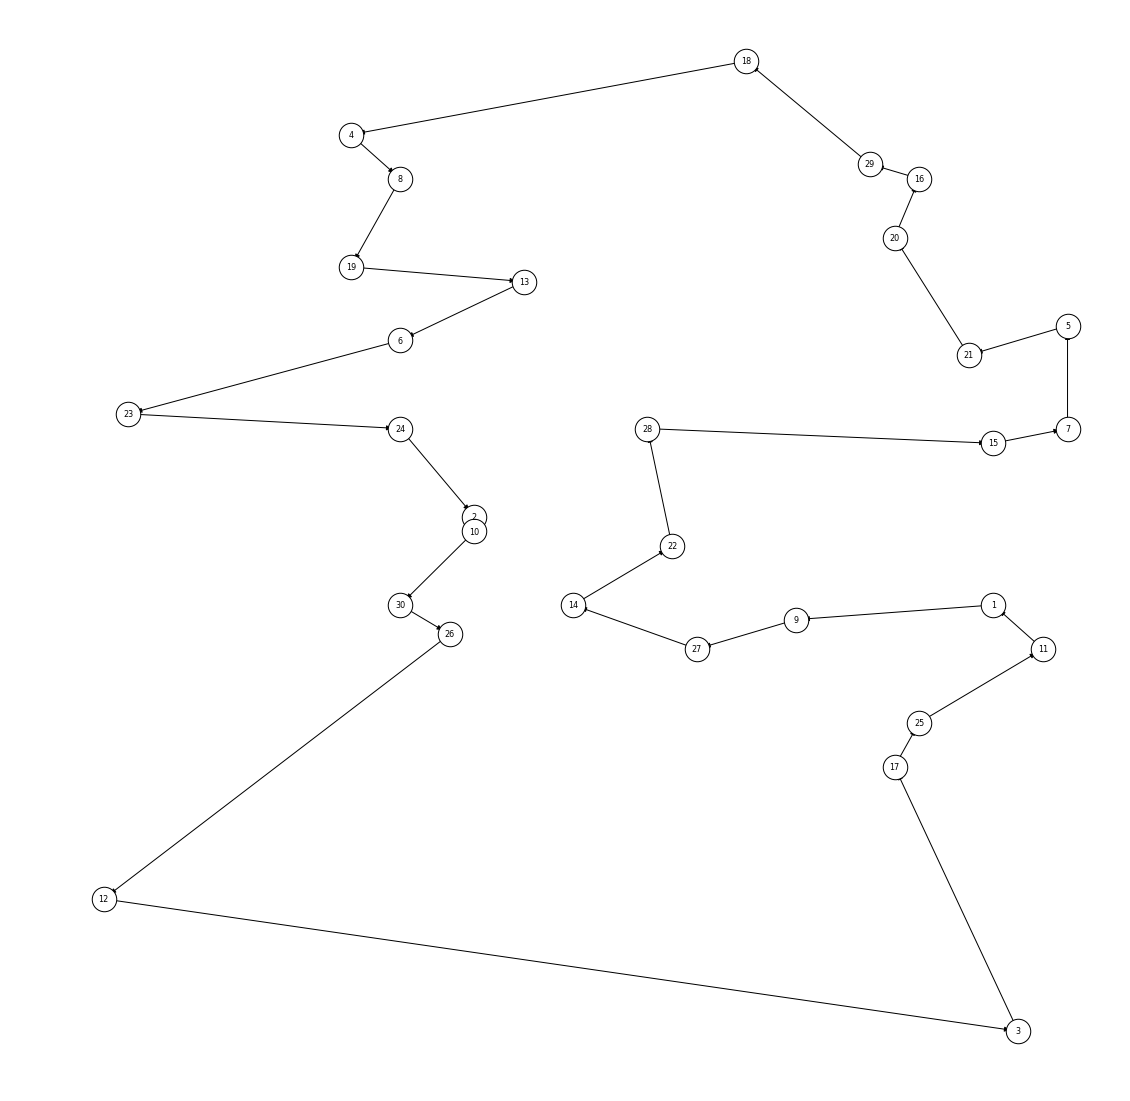

In [22]:
DrawSol(G,x)

The solution does not change as the solution to question 1 already fulfills the constraints on node 16.

* **Delivery cost: 27720**
* **Vehicle cost: 1100**
* **Storage cost: 2100**

### Total cost: 30920

## Question 3
In this case, the model is a mTSP with $m=2$ and $p = 18$

In [23]:
m = 2
p = 18

mtsp_mtz = gb.Model()

x = mtsp_mtz.addVars(G.edges(),\
                 obj=[G[i][j]['dist']\
                      for i,j in G.edges()],\
             vtype=gb.GRB.BINARY, name='x')

u = mtsp_mtz.addVars(G.nodes(), obj=0.0, vtype=gb.GRB.CONTINUOUS,\
                     lb=1.0, ub=p, name='u')

mtsp_mtz.write('mtsp_mtz.lp')

mtsp_mtz.addConstr(x.sum(root,'*') == m, name = 'OUT-R')
mtsp_mtz.addConstr(x.sum('*',root) == m, name = 'IN-R')
mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

mtsp_mtz.addConstrs((x.sum(i,'*') == 1 \
                 for i in G.nodes() if i != root), name='FS')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

mtsp_mtz.addConstrs((x.sum('*',i) == 1 \
                 for i in G.nodes() if i != root), name='RS')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

mtsp_mtz.addConstrs((x[i,j] + x[j,i] <= 1 \
                 for i,j in G.edges() if j > i \
                     and i != root and j != root ), name='SUB2')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

u[root].lb = 0
u[root].ub = 0

mtsp_mtz.addConstrs((u[i] - u[j] + p * x[i,j] <= p - 1 \
                     for i in G.nodes() for j in G.nodes()\
                    if i != j and i != root and j != root and G.has_edge(i,j)), name='MTZ')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

In [24]:
mtsp_mtz.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1278 rows, 900 columns and 4988 nonzeros
Model fingerprint: 0x3140477a
Variable types: 30 continuous, 870 integer (870 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [2e+02, 7e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolved: 1278 rows, 899 columns, 4988 nonzeros
Variable types: 29 continuous, 870 integer (870 binary)
Found heuristic solution: objective 84712.000000

Root relaxation: objective 2.750978e+04, 134 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 27509.7778    0   41 84712.0000 27509.7778  67.5%     -    0s
H    0     0                    35619.000000 

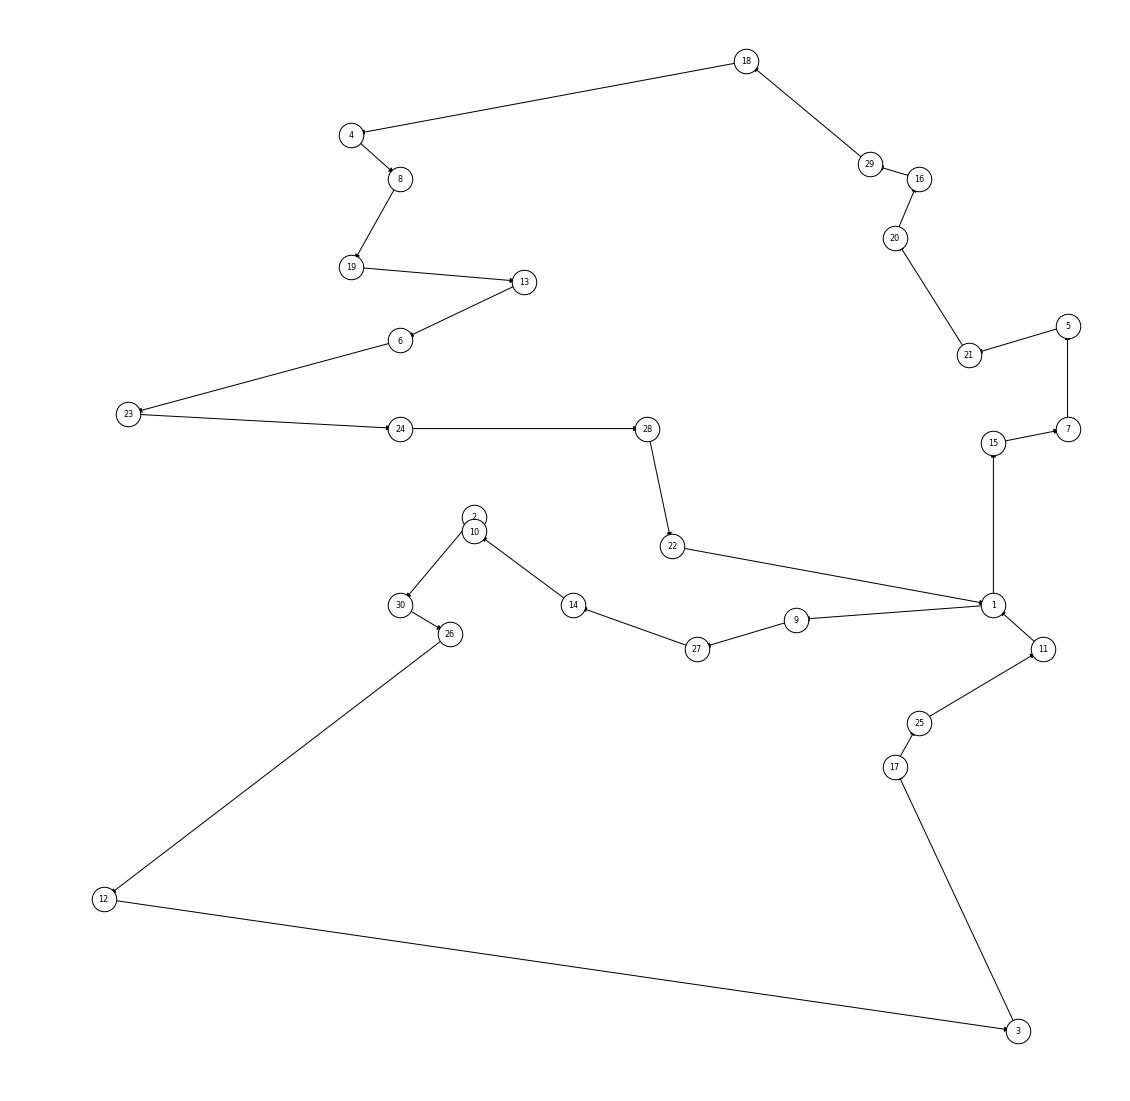

In [25]:
DrawSol(G,x)

* **Delivery cost: 29329**
    
* **Vehicle cost: 1650*2**

* **Storage cost: 0**

### Total cost: 32629

## The most convenient delivering plan is the strategy 2